In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
from torchvision.transforms import ToTensor
dataset = MNIST(root='data/',download=True, transform = ToTensor())

torch.Size([1, 28, 28])
5


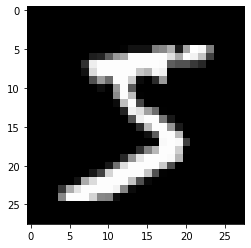

In [4]:
img, label = dataset[0]
print(img.shape)
print(label)
plt.imshow(img.reshape((28, 28)), cmap='gray')

In [5]:
from torch.utils.data import random_split
val_size = 10_000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
from torch.utils.data.dataloader import DataLoader
btch = 128
train_dl = DataLoader(train_ds, btch, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, btch, num_workers=4, pin_memory=True)


torch.Size([1, 28, 28])


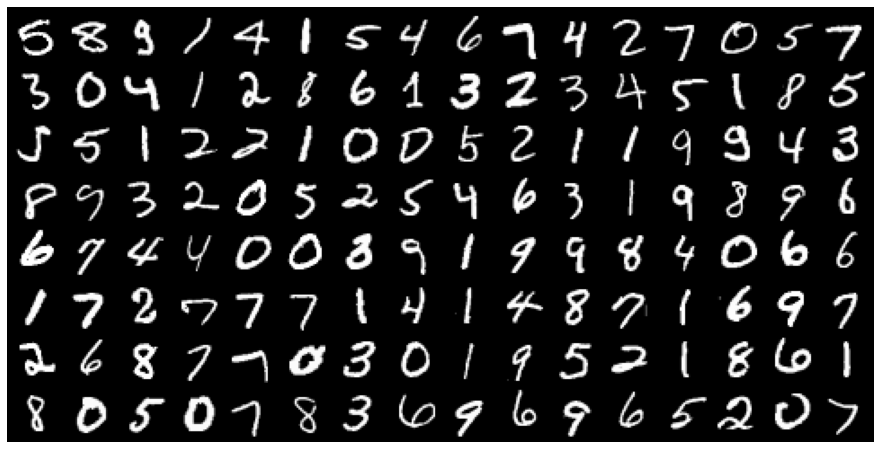

In [7]:
from torchvision.utils import make_grid
for imgs, lbl in train_dl:
    print(img.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(imgs, nrow=16).permute((1, 2, 0)))
    break

In [8]:
for imgs, _ in train_dl:
    inputs = imgs.reshape(-1,(28*28)) # =>(btch,img.flatten)
    print(inputs.shape)
    break

torch.Size([128, 784])


In [9]:
for imgs, _ in train_dl:
    inputs = imgs.reshape(-1,(28*28)) # =>(btch,img.flatten)
    print(inputs)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [73]:
import torch.nn as nn
import torch.nn.functional as F
class MNISTModel(nn.Module):
    def __init__(self,input_neurons,hidden_neurons, output):
        super().__init__()
        self.lyr_1 = nn.Linear(input_neurons, hidden_neurons)
        self.lyr_2 = nn.Linear(hidden_neurons, output)

    def forward(self, xbtch):
        xbtch = xbtch.view(xbtch.size(0), -1) 
        out = self.lyr_1(xbtch)
        out = F.relu(out) #apply relu on the output
        out = self.lyr_2(out)
        return out

    def training_step(self, btch):
        imgs, labels = btch
        out = self(imgs) #run the forward method on the images
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, btch):
        imgs, labels = btch
        out =self(imgs)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_acc':acc, 'val_loss':loss}

    
    def validation_epoch_end(self, outputs):
        btch_losses = [x['val_loss'] for x in outputs]
        btch_acc = [x['val_acc'] for x in outputs]
        # combine the losses & accuracies
        epoch_loss = torch.stack(btch_losses).mean() 
        epoch_acc = torch.stack(btch_acc).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(self, epoch, results):
        print(f"Epoch [{epoch}], validation_loss: {results['val_loss']:4f}, valdation_acc: {results['val_acc']:4f}")
    


In [74]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [75]:
input_neurons = 28*28
hidden_size = 32
num_classes= 10 #labels 

In [76]:
model = MNISTModel(input_neurons, hidden_size, num_classes)

# USING GPUS IF AVALIABLE

In [77]:
def SetGPU():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [78]:
device = SetGPU()
device

device(type='cuda')

In [79]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [80]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for btch in self.dl:
            yield to_device(btch, self.device)
    def __len__(self):
        return len(dl)

In [81]:
train_dl = DeviceDataLoader(train_dl, device)
vdl = DeviceDataLoader(val_dl, device)

In [82]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(btch) for btch in val_loader]
    return model.validation_epoch_end(outputs)

In [83]:
def fit(model, epochs, lr, train_loader,val_loader,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #training phase
        for btch in train_loader:
            loss = model.training_step(btch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [84]:
to_device(model, device)

MNISTModel(
  (lyr_1): Linear(in_features=784, out_features=32, bias=True)
  (lyr_2): Linear(in_features=32, out_features=10, bias=True)
)

In [85]:
history = [evaluate(model,vdl)]
history

[{'val_acc': 0.08890426903963089, 'val_loss': 2.3173511028289795}]

In [86]:
history += fit(model, 30, 5e-3, train_dl, vdl)

Epoch [0], validation_loss: 1.900203, valdation_acc: 0.618275
Epoch [1], validation_loss: 1.335908, valdation_acc: 0.724585
Epoch [2], validation_loss: 0.943741, valdation_acc: 0.792029
Epoch [3], validation_loss: 0.746366, valdation_acc: 0.822686
Epoch [4], validation_loss: 0.635966, valdation_acc: 0.843453
Epoch [5], validation_loss: 0.566887, valdation_acc: 0.854035
Epoch [6], validation_loss: 0.519032, valdation_acc: 0.862441
Epoch [7], validation_loss: 0.484336, valdation_acc: 0.868869
Epoch [8], validation_loss: 0.458532, valdation_acc: 0.874703
Epoch [9], validation_loss: 0.438187, valdation_acc: 0.875890
Epoch [10], validation_loss: 0.421351, valdation_acc: 0.879846
Epoch [11], validation_loss: 0.407472, valdation_acc: 0.884494
Epoch [12], validation_loss: 0.396537, valdation_acc: 0.884988
Epoch [13], validation_loss: 0.386663, valdation_acc: 0.888845
Epoch [14], validation_loss: 0.377688, valdation_acc: 0.890229
Epoch [15], validation_loss: 0.370265, valdation_acc: 0.892207
Ep

In [87]:
history += fit(model, 30, 1e-3, train_dl, vdl)

Epoch [0], validation_loss: 0.313424, valdation_acc: 0.909217
Epoch [1], validation_loss: 0.312921, valdation_acc: 0.909810
Epoch [2], validation_loss: 0.312619, valdation_acc: 0.910008
Epoch [3], validation_loss: 0.312022, valdation_acc: 0.910008
Epoch [4], validation_loss: 0.311544, valdation_acc: 0.910305
Epoch [5], validation_loss: 0.311044, valdation_acc: 0.910403
Epoch [6], validation_loss: 0.310661, valdation_acc: 0.910403
Epoch [7], validation_loss: 0.310170, valdation_acc: 0.910502
Epoch [8], validation_loss: 0.309676, valdation_acc: 0.910799
Epoch [9], validation_loss: 0.309264, valdation_acc: 0.910799
Epoch [10], validation_loss: 0.308806, valdation_acc: 0.910898
Epoch [11], validation_loss: 0.308401, valdation_acc: 0.910700
Epoch [12], validation_loss: 0.308048, valdation_acc: 0.911491
Epoch [13], validation_loss: 0.307526, valdation_acc: 0.911392
Epoch [14], validation_loss: 0.307060, valdation_acc: 0.911392
Epoch [15], validation_loss: 0.306616, valdation_acc: 0.911491
Ep

In [89]:
history += fit(model, 30, 1e-4, train_dl, vdl)

Epoch [0], validation_loss: 0.299896, valdation_acc: 0.913667
Epoch [1], validation_loss: 0.299860, valdation_acc: 0.913766
Epoch [2], validation_loss: 0.299823, valdation_acc: 0.913766
Epoch [3], validation_loss: 0.299788, valdation_acc: 0.913766
Epoch [4], validation_loss: 0.299751, valdation_acc: 0.913766
Epoch [5], validation_loss: 0.299716, valdation_acc: 0.913766
Epoch [6], validation_loss: 0.299679, valdation_acc: 0.913865
Epoch [7], validation_loss: 0.299643, valdation_acc: 0.913865
Epoch [8], validation_loss: 0.299607, valdation_acc: 0.913964
Epoch [9], validation_loss: 0.299570, valdation_acc: 0.913964
Epoch [10], validation_loss: 0.299535, valdation_acc: 0.914062
Epoch [11], validation_loss: 0.299497, valdation_acc: 0.914062
Epoch [12], validation_loss: 0.299461, valdation_acc: 0.914062
Epoch [13], validation_loss: 0.299426, valdation_acc: 0.914062
Epoch [14], validation_loss: 0.299390, valdation_acc: 0.914062
Epoch [15], validation_loss: 0.299355, valdation_acc: 0.914062
Ep

In [91]:
import os
os.listdir()

['.config', 'drive', 'data', 'sample_data']

In [96]:
# torch.save(model, 'drive/MyDrive/programming_project/digitLinearModel.pth')
torch.save(model.state_dict(), 'drive/MyDrive/programming_project/digit_state_dict.pth')